In [4]:
from imports import *

hps = {'batch_size': 14,
 'hidden_size': 30,
 'lookback': 14,
 'lr': 0.0003,
 'n_epochs': 500,
 'num_layers': 1,
 'output_size': 1,
 'final_train_loss': 0.0298684760928154,
 'final_test_loss': 0.027125000953674316
}

In [5]:
%load_ext autoreload
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [6]:
warnings.filterwarnings("ignore")

#### Load data, split and create dataset

In [7]:
timeseries = process_file()
len(timeseries)

154

In [8]:
train_size = int(len(timeseries) * 0.67)
test_size = len(timeseries) - train_size
train, test = timeseries[:train_size], timeseries[train_size:]

In [9]:
lookback=14
X_train, y_train = create_dataset(train, lookback=lookback)
X_test, y_test = create_dataset(test, lookback=lookback)

from utils import scale_data

X_train, X_test, y_train, y_test, scaler_x, scaler_y = scale_data(X_train, X_test, y_train, y_test)

print("X_train", X_train.shape, "y_train", y_train.shape)
print("X_test",X_test.shape, "y_test",y_test.shape)

X_train torch.Size([89, 14, 1]) y_train torch.Size([89, 14, 1])
X_test torch.Size([37, 14, 1]) y_test torch.Size([37, 14, 1])


#### Defining LSTM Model and hyperparameters

In [10]:
from model import LSTMModel

model = LSTMModel(input_size=lookback, num_layers=1, hidden_size=30)
optimizer = optim.Adam(model.parameters(), lr=0.0003)
loss_fn = nn.MSELoss()
loader = data.DataLoader(data.TensorDataset(X_train, y_train), shuffle=True, batch_size=14, drop_last=True)

#### Training

In [11]:
from model import train_model
train_loss, train_rmse = train_model(model, loader, optimizer, loss_fn, 
                                     n_epochs=500, print_interval=50, seed=42)

In [12]:
X_train.shape

torch.Size([89, 14, 1])

#### Evaluating on train and test

In [13]:
from model import evaluate_model_last_prediction
train_preds, train_loss, test_loss, train_rmse, test_rmse, test_preds = evaluate_model_last_prediction(model, X_train, y_train, X_test, y_test, scaler_y, loss_fn)

In [14]:
# creo un array concatenando las predicciones
train_preds = np.concatenate([tensor.flatten() for tensor in train_preds])
test_preds = np.concatenate([tensor.flatten() for tensor in test_preds])
len(train_preds), len(test_preds)

(89, 37)

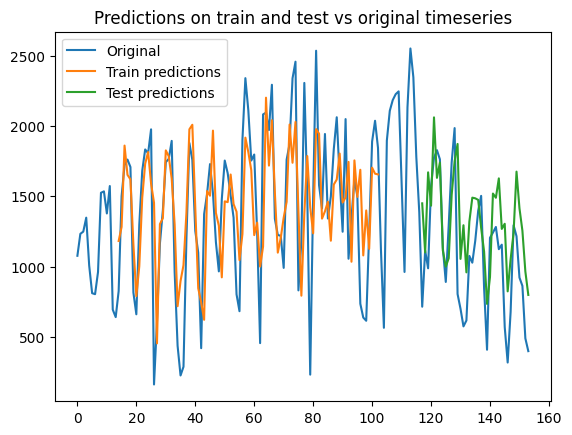

In [16]:
plt.plot(timeseries, label="Original")
plt.plot(range(lookback, lookback + len(train_preds)), train_preds, label="Train predictions")
plt.plot(range(2*lookback + len(train_preds), 2*lookback + len(train_preds) + len(test_preds)), test_preds, label="Test predictions")
plt.title("Predictions on train and test vs original timeseries")
plt.legend()

In [281]:
test_loss, train_loss

([0.03694296255707741], [0.0240829698741436])

#### Plotting correlation results

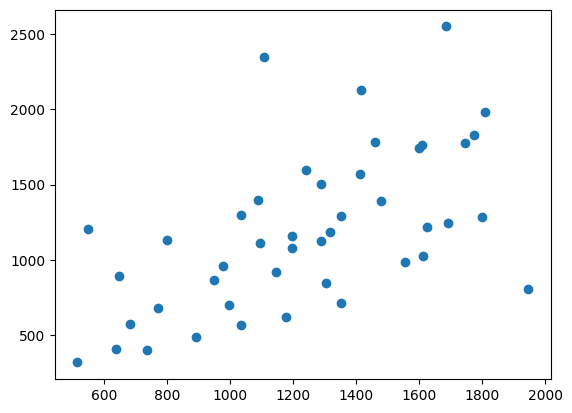

In [305]:
plt.scatter(test_preds, test[lookback:])

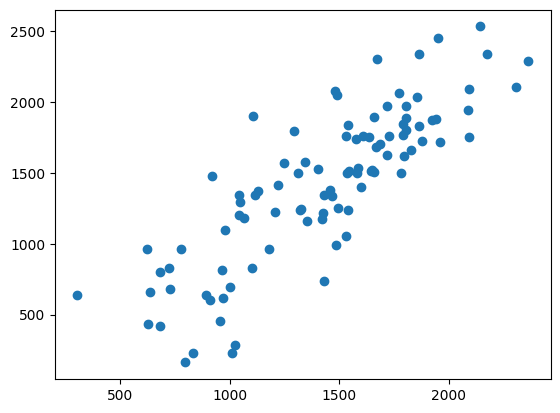

In [306]:
plt.scatter(train_preds, train[lookback:])